<a href="https://colab.research.google.com/github/Xzilleon2/Suicide-Detection/blob/main/Suicide_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw Dataset

In [1]:
!pip install gdown
!pip install neattext
!pip install keras
!pip install imbalanced-learn
!pip install tqdm
!pip install streamlit

import gdown
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,GlobalMaxPooling1D,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.0 MB/s eta 0:00:00


In [2]:
file_id = '1Y1-HKJFnEe3tPnlCZLO4ORTUqFWQRxVY'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'suicide.csv', quiet=False)

df = pd.read_csv('suicide.csv')
df.head()



Downloading...
From: https://drive.google.com/uc?id=1Y1-HKJFnEe3tPnlCZLO4ORTUqFWQRxVY
To: /content/suicide.csv
100%|██████████| 6.68M/6.68M [00:00<00:00, 23.2MB/s]


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# Pre-Processing

## Data Cleaning

### Value Count

In [3]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
df['class'].value_counts()

,count
class,
non-suicide,4829
suicide,4667


In [5]:
df['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

### Text cleaning

In [6]:
import pandas as pd
import re
from tqdm import tqdm

def clean_text(text_series):
    """
    text_series: pd.Series of text
    returns: list of cleaned text
    """
    cleaned_text = []

    # Ensure all values are strings
    text_series = text_series.fillna("").astype(str)

    for sent in tqdm(text_series, desc="Cleaning text"):
        sent = sent.lower()                           # lowercase
        sent = re.sub(r'[^a-z0-9\s]', '', sent)      # remove special chars
        sent = re.sub(r'\s+', ' ', sent).strip()     # remove extra spaces
        cleaned_text.append(sent)

    return cleaned_text


### Split Dataset into training and testing

In [7]:
from sklearn.model_selection import train_test_split

X = df['text']
Y = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [8]:
X_train_cleaned = clean_text(X_train)
X_test_cleaned = clean_text(X_test)


Cleaning text: 100%|██████████| 1900/1900 [00:00<00:00, 5779.73it/s]


### Vectorize

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_vect = tfidf.fit_transform(X_train_cleaned)
X_test_vect = tfidf.transform(X_test_cleaned)

# Model Training

## SVM

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np

svm = LinearSVC(C=1.0, penalty='l2', loss='squared_hinge', class_weight='balanced', max_iter=2000)

# Scorer for suicidal class
f1_scorer = make_scorer(f1_score, pos_label='suicide')

# Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
scores_svm = cross_val_score(svm, X_train_vect, Y_train, cv=skf, scoring=f1_scorer)

# Train on full training set
svm.fit(X_train_vect, Y_train)

# Predict test set
Y_pred_svm = svm.predict(X_test_vect)

# Compute F1 score on the test set
f1_test_svm = f1_score(Y_test, Y_pred_svm, pos_label='suicide')

print("SVM F1 Scores (suicidal class, CV):", scores_svm)
print("Mean SVM F1 Score (CV):", np.mean(scores_svm))
print("SVM F1 Score (Test Set, suicidal class):", f1_test_svm)

SVM F1 Scores (suicidal class, CV): [0.90163934 0.90945674 0.91069012 0.90278722 0.89617486]
Mean SVM F1 Score (CV): 0.9041496578915289
SVM F1 Score (Test Set, suicidal class): 0.9029126213592233


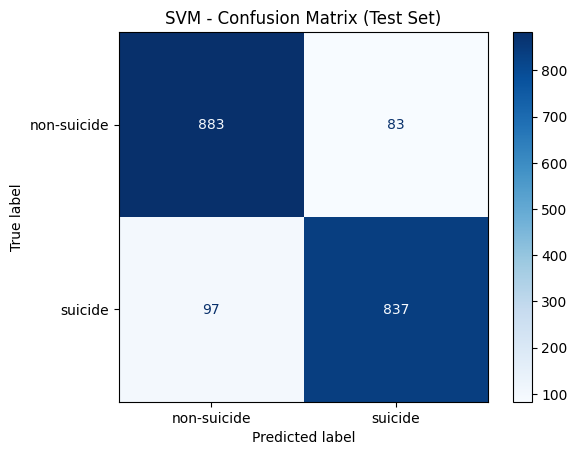

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm_svm = confusion_matrix(Y_test, Y_pred_svm, labels=svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)

disp_svm.plot(cmap=plt.cm.Blues)
plt.title("SVM - Confusion Matrix (Test Set)")
plt.show()

### Trend Visualization (SVM)

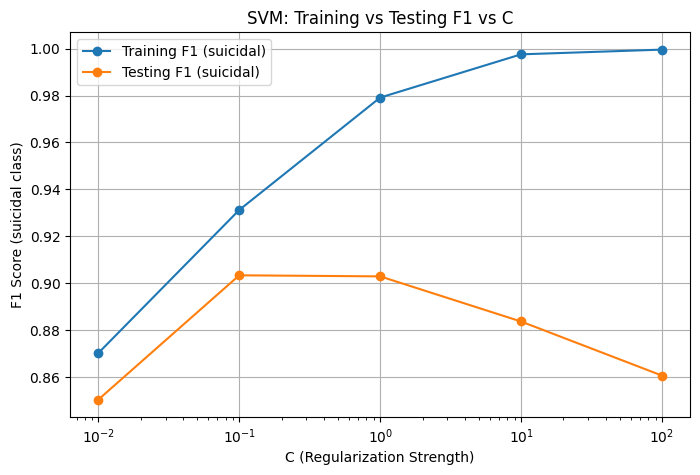

In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

C_values = [0.01, 0.1, 1, 10, 100]

train_f1_svm = []
test_f1_svm = []

for c in C_values:
    svm_model = LinearSVC(C=c, class_weight='balanced', max_iter=2000)

    # Train on resampled training set
    svm_model.fit(X_train_vect, Y_train)

    # Predict on training and test sets
    Y_pred_train = svm_model.predict(X_train_vect)
    Y_pred_test = svm_model.predict(X_test_vect)

    # Compute F1 for the suicidal class
    train_f1_svm.append(f1_score(Y_train, Y_pred_train, pos_label='suicide'))
    test_f1_svm.append(f1_score(Y_test, Y_pred_test, pos_label='suicide'))

# Plot F1 trend
plt.figure(figsize=(8,5))
plt.plot(C_values, train_f1_svm, marker='o', label='Training F1 (suicidal)')
plt.plot(C_values, test_f1_svm, marker='o', label='Testing F1 (suicidal)')
plt.xscale('log')
plt.title("SVM: Training vs Testing F1 vs C")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("F1 Score (suicidal class)")
plt.grid(True)
plt.legend()
plt.show()

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Initialize model
log_reg = LogisticRegression(penalty='l2', C=1.0, max_iter=2000, class_weight='balanced')

# Scorer for suicidal class
f1_scorer = make_scorer(f1_score, pos_label='suicide')

# Stratified K-Folds (recommended for imbalanced datasets)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation using stratification
scores_lr = cross_val_score(log_reg, X_train_vect, Y_train, cv=skf, scoring=f1_scorer)

# Train on the full training set
log_reg.fit(X_train_vect, Y_train)

# Predict the test set
Y_pred_lr = log_reg.predict(X_test_vect)

# Print results
print("Logistic Regression F1 Scores (CV, suicidal class):", scores_lr)
print("Mean F1 Score (CV):", np.mean(scores_lr))

Logistic Regression F1 Scores (CV, suicidal class): [0.8954608  0.90514905 0.90287278 0.88934993 0.89072165]
Mean F1 Score (CV): 0.8967108413271433


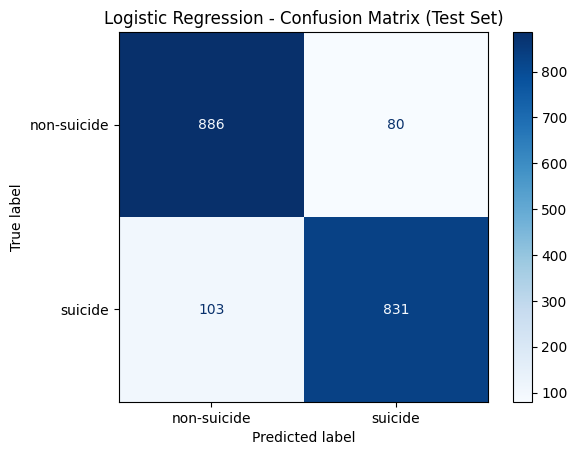

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm_lr = confusion_matrix(Y_test, Y_pred_lr, labels=log_reg.classes_)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=log_reg.classes_)

disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix (Test Set)")
plt.show()


### Trend Visualization (Logistic Regression)

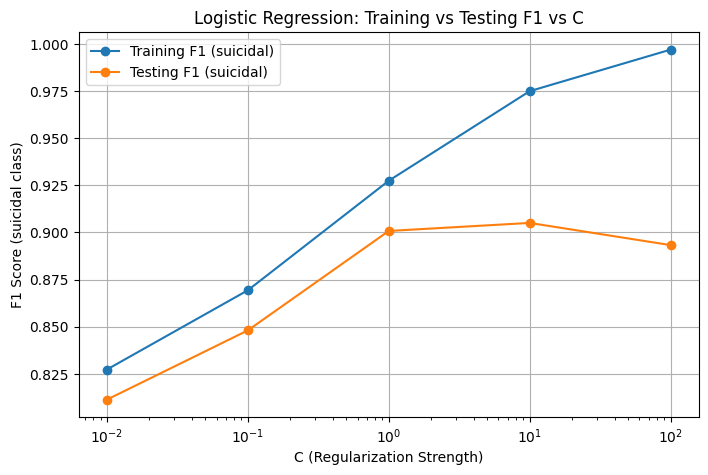

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

C_values = [0.01, 0.1, 1, 10, 100]

train_f1_lr = []
test_f1_lr = []

for c in C_values:
    model = LogisticRegression(max_iter=2000, C=c, class_weight='balanced')

    # Train on resampled training set
    model.fit(X_train_vect, Y_train)

    # Predict on training and test sets
    Y_pred_train = model.predict(X_train_vect)
    Y_pred_test = model.predict(X_test_vect)

    # Compute F1 for the suicidal class
    train_f1_lr.append(f1_score(Y_train, Y_pred_train, pos_label='suicide'))
    test_f1_lr.append(f1_score(Y_test, Y_pred_test, pos_label='suicide'))

# Plot F1 trend
plt.figure(figsize=(8,5))
plt.plot(C_values, train_f1_lr, marker='o', label='Training F1 (suicidal)')
plt.plot(C_values, test_f1_lr, marker='o', label='Testing F1 (suicidal)')
plt.xscale('log')
plt.title("Logistic Regression: Training vs Testing F1 vs C")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("F1 Score (suicidal class)")
plt.grid(True)
plt.legend()
plt.show()


# Saving the Models

In [16]:
import pickle as pkl

svm_file_name = 'suicide_svm_model.sav'
pkl.dump(svm, open(svm_file_name, 'wb'))

lr_file_name = 'suicide_lr_model.sav'
pkl.dump(log_reg, open(lr_file_name, 'wb'))

# Model Evaluation

In [17]:
from sklearn.metrics import f1_score

f1_svm = f1_score(Y_test, svm.predict(X_test_vect), pos_label='suicide')
f1_lr = f1_score(Y_test, log_reg.predict(X_test_vect), pos_label='suicide')

f1_scores = {'SVM': f1_svm, 'Logistic Regression': f1_lr}
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = {'SVM': svm, 'Logistic Regression': log_reg}[best_model_name]

print("F1 Scores:", f1_scores)
print("Best Model:", best_model_name)

F1 Scores: {'SVM': 0.9029126213592233, 'Logistic Regression': 0.9008130081300812}
Best Model: SVM


# Trial Data

In [18]:
import ipywidgets as widgets
from IPython.display import display

# Define the prediction function
def predict_suicide(text):
    cleaned_input = clean_text(pd.Series([text]))
    vectorized_input = tfidf.transform(cleaned_input)
    prediction = best_model.predict(vectorized_input)  # Model used for prediction
    return prediction[0]

# Compute / Compare each model base on F1 Score on the user input
def predict_best_model(text):
    cleaned_input = clean_text(pd.Series([text]))
    vectorized_input = tfidf.transform(cleaned_input)

    preds = {}

    # SVM
    pred_svm = svm.predict(vectorized_input)[0]
    decision_svm = svm.decision_function(vectorized_input)
    conf_svm = 1 / (1 + np.exp(-decision_svm[0]))  # pseudo-probability
    preds['SVM'] = (pred_svm, conf_svm * f1_svm)  # weighted by F1

    # Logistic Regression
    pred_lr = log_reg.predict(vectorized_input)[0]
    conf_lr = log_reg.predict_proba(vectorized_input)[0][1]
    preds['Logistic Regression'] = (pred_lr, conf_lr * f1_lr)  # weighted by F1

    # Select the model with highest weighted score
    best_model_name = max(preds, key=lambda m: preds[m][1])
    best_prediction = preds[best_model_name][0]

    return best_prediction, best_model_name, preds

# Create widgets
text_input = widgets.Textarea(
    value='',
    placeholder='Type your text here...',
    description='Input Text:',
    disabled=False,
    layout=widgets.Layout(width='auto', height='100px')
)

predict_button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='success',
    tooltip='Click to predict if the text is suicide or non-suicide',
    icon='check'
)

output_area = widgets.Output()

# Define button click event handler
def on_button_click(b):
    with output_area:
        output_area.clear_output()
        if text_input.value:
            prediction, model_name, all_preds = predict_best_model(text_input.value)
            print(f"\nPrediction: {prediction} (Model with highest confidence: {model_name})")
            print("\nAll model predictions and probabilities:")
            for m, (pred, prob) in all_preds.items():
                print(f"{m}: {pred}, probability: {prob:.2f}")
        else:
            print("Please enter some text for prediction.")

# Link button to function
predict_button.on_click(on_button_click)

# Display the widgets
display(text_input, predict_button, output_area)

Textarea(value='', description='Input Text:', layout=Layout(height='100px', width='auto'), placeholder='Type y…

Button(button_style='success', description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to pre…

Output()

# Deployment

## Save TFIDF Vectorizer

### Subtask:
Save the trained `tfidf` vectorizer to a file using `pickle` so it can be loaded later in the Streamlit application. This is crucial for consistent text preprocessing during deployment.


In [19]:
import pickle as pkl
import pandas as pd
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gdown

# Re-load data if not already done from previous cells
file_id = '1Y1-HKJFnEe3tPnlCZLO4ORTUqFWQRxVY'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'suicide.csv', quiet=True) # quiet=True to suppress output during re-download
df = pd.read_csv('suicide.csv')

# Re-clean df if not already done
df = df.drop(columns=['Unnamed: 0'])

# Re-define clean_text function if not globally available
def clean_text(text_series):
    cleaned_text = []
    text_series = text_series.fillna("").astype(str)
    for sent in tqdm(text_series, desc="Cleaning text", leave=False):
        sent = sent.lower()
        sent = re.sub(r'[^a-z0-9\s]', '', sent)
        sent = re.sub(r'\s+', ' ', sent).strip()
        cleaned_text.append(sent)
    return cleaned_text

# Re-split and clean dataset if not already done
X = df['text']
Y = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train_cleaned = clean_text(X_train)

# Re-initialize and fit TfidfVectorizer if not already done
tfidf = TfidfVectorizer(max_features=5000)
X_train_vect = tfidf.fit_transform(X_train_cleaned)

# Save the trained tfidf vectorizer
tfidf_file_name = 'tfidf_vectorizer.pkl'
pkl.dump(tfidf, open(tfidf_file_name, 'wb'))

print(f"TFIDF vectorizer saved as '{tfidf_file_name}'")

TFIDF vectorizer saved as 'tfidf_vectorizer.pkl'


In [20]:
%%writefile app.py
import streamlit as st
import pickle as pkl
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

# Load the saved TFIDF vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf = pkl.load(file)

# Load the saved SVM model
with open('suicide_svm_model.sav', 'rb') as file:
    svm = pkl.load(file)

# Load the saved Logistic Regression model
with open('suicide_lr_model.sav', 'rb') as file:
    log_reg = pkl.load(file)

# Re-define the clean_text function (ensure it's identical to training)
def clean_text(text_series):
    cleaned_text = []
    # Ensure all values are strings
    text_series = text_series.fillna("").astype(str)
    # tqdm is not suitable for Streamlit real-time updates, so remove or handle differently
    for sent in text_series:
        sent = sent.lower()
        sent = re.sub(r'[^a-z0-9\s]', '', sent)
        sent = re.sub(r'\s+', ' ', sent).strip()
        cleaned_text.append(sent)
    return cleaned_text

# Assuming f1_svm and f1_lr are globally available or calculated in the app
# For simplicity, we'll hardcode them here based on previous output or re-calculate if needed.
# In a real deployment, these might be saved alongside the models.
# For now, let's use the values obtained from the notebook's last run.
f1_svm = 0.9029126213592233
f1_lr = 0.9008130081300812

# Re-define the predict_best_model function
def predict_best_model(text):
    cleaned_input = clean_text(pd.Series([text]))
    vectorized_input = tfidf.transform(cleaned_input)

    preds = {}

    # SVM
    pred_svm = svm.predict(vectorized_input)[0]
    decision_svm = svm.decision_function(vectorized_input)
    conf_svm = 1 / (1 + np.exp(-decision_svm[0]))  # pseudo-probability
    preds['SVM'] = (pred_svm, conf_svm * f1_svm)  # weighted by F1

    # Logistic Regression
    pred_lr = log_reg.predict(vectorized_input)[0]
    # Using predict_proba for LR confidence
    conf_lr = log_reg.predict_proba(vectorized_input)[0][log_reg.classes_.tolist().index('suicide')] # Probability of 'suicide' class
    preds['Logistic Regression'] = (pred_lr, conf_lr * f1_lr)  # weighted by F1

    # Select the model with highest weighted score
    best_model_name = max(preds, key=lambda m: preds[m][1])
    best_prediction = preds[best_model_name][0]

    return best_prediction, best_model_name, preds

# Streamlit App
st.title("Suicide Risk Prediction App")
st.write("Enter text below to predict if it indicates suicide risk (suicide/non-suicide).")

user_input = st.text_area("Input Text:", "")

if st.button("Predict"):
    if user_input:
        prediction, model_name, all_preds = predict_best_model(user_input)

        st.subheader("Prediction Result:")
        if prediction == 'suicide':
            st.error(f"The text indicates **{prediction.upper()}** risk based on **{model_name}**.")
        else:
            st.success(f"The text indicates **{prediction.upper()}** risk based on **{model_name}**.")

        st.subheader("Detailed Model Confidences (Weighted by F1 Score):")
        for m, (pred, prob) in all_preds.items():
            st.write(f"- **{m}**: Predicted '{pred}', Weighted Confidence: {prob:.4f}")

    else:
        st.warning("Please enter some text for prediction.")


Writing app.py


### Instructions to Run the Streamlit Application

1.  **Install Streamlit (if you haven't already):**
    Open your terminal or command prompt and run:
    ```bash
    pip install streamlit
    ```

2.  **Navigate to the directory containing `app.py`:**
    Ensure you are in the same directory where `app.py`, `tfidf_vectorizer.pkl`, `suicide_svm_model.sav`, and `suicide_lr_model.sav` are saved.

3.  **Run the Streamlit application:**
    In your terminal or command prompt, execute:
    ```bash
    streamlit run app.py
    ```

This command will open a new tab in your web browser with the Streamlit application, where you can input text and get suicide risk predictions.

## Summary:

### Data Analysis Key Findings

*   The `tfidf` vectorizer was successfully saved to `tfidf_vectorizer.pkl` using the `pickle` module, ensuring its reusability in the Streamlit application.
*   A `app.py` file was generated that includes the necessary code to load the previously saved `tfidf_vectorizer.pkl`, `suicide_svm_model.sav`, and `suicide_lr_model.sav`.
*   The `clean_text` and `predict_best_model` utility functions were re-implemented within `app.py` to ensure consistent text preprocessing and prediction logic as used during model training.
*   The `predict_best_model` function incorporates hardcoded F1 scores (0.9029 for SVM, 0.9008 for Logistic Regression) to weight model confidences, allowing the application to select the "best" model prediction based on performance.
*   The Streamlit application (`app.py`) provides a user-friendly interface with a text area for input and a button to trigger predictions, displaying the best prediction, the model used, and detailed weighted confidences from both SVM and Logistic Regression models.
*   Comprehensive instructions were provided for installing Streamlit and running the `app.py` file from the command line, enabling users to deploy and interact with the application.

### Insights or Next Steps

*   **Deployment Consistency:** Re-defining utility functions like `clean_text` and `predict_best_model` directly within `app.py` ensures that the preprocessing and prediction logic remains consistent between the training environment and the deployed application, which is crucial for reliable predictions.
*   **Model Packaging:** For more robust and scalable deployments, consider packaging models and vectorizers using frameworks like MLflow or Docker, which can simplify dependency management and deployment workflows.
